In [1]:
import numpy as np
import sys
sys.path.append('/Users/jerometubiana/Documents/GitHub/PGM3/source/')
sys.path.append('/Users/jerometubiana/Documents/GitHub/PGM3/utilities/')
import bm
import utilities
from scipy.linalg import eigh
import matplotlib.pyplot as plt

/Users/jerometubiana/Documents/GitHub/PGM3/source/numba_utilities.py:14: NumbaWarning: Cannot cache compiled function "dot_Potts_C" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(signature, parallel=True, cache=True, nogil=False)
/Users/jerometubiana/Documents/GitHub/PGM3/source/numba_utilities.py:32: NumbaWarning: Cannot cache compiled function "dot_Potts2_C" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(signature, parallel=True, cache=True, nogil=False)
/Users/jerometubiana/Documents/GitHub/PGM3/source/numba_utilities.py:50: NumbaWarning: Cannot cache compiled function "dot_Potts3_C" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(signature, parallel=True, cache=True, nogil=False)
/Users/jerometubiana/Documents/GitHub/PGM3/source/numba_utilities.py:91: NumbaWarning: Cannot cache compiled function "compute_output_C" as it uses dynamic globals (such as ctypes pointers and l

# Generate data from a discrete XY model
- We use discrete angles $\frac{2\pi c}{n_c}$, $c \in [0, n_c-1]$.
- Energy function takes form E = - $\sum_i \cos (\theta_i - \theta_{i+1})$
- Data is generated with a Potts model.
- Show descriptive statistics: Top eigenvector, correlation matrix.


In [32]:
N = 100
beta = 1.5
n_c = 10
thetas = 2*np.pi/n_c * np.arange(n_c)
costhetas = np.cos(thetas[np.newaxis]-thetas[:,np.newaxis])

BM = bm.BM(N=N,n_c=n_c,nature='Potts')
J = np.zeros([N,N,n_c,n_c])
for n in range(N-1):
    J[n,n+1,:,:] = beta * costhetas
    J[n+1,n,:,:] = beta * costhetas.T
J[N-1,0,:,:] = beta * costhetas
J[0,N-1,:,:] = beta * costhetas.T

BM.layer.couplings = J.astype(np.float32)


data = BM.gen_data(Nchains=100,Lchains=10000,Nthermalize=1000,Nstep=300)
C = utilities.covariance(data,data,c1=n_c,c2=n_c)
diag = C[np.arange(N),np.arange(N),:,:][:,np.arange(n_c),np.arange(n_c)]
C/= np.sqrt(diag[:,np.newaxis,:,np.newaxis] * diag[np.newaxis,:,np.newaxis,:])

C2D = np.swapaxes(C,1,2).reshape([n_c*N,n_c*N]) # Does the same thing as the commented code below.

# C2D = np.zeros([N*n_c,N*n_c])
# for i1 in range(N):
#     for i2 in range(N):
#         for c1 in range(n_c):
#             for c2 in range(n_c):
#                 C2D[i1*n_c+c1,i2*n_c+c2] = C[i1,i2,c1,c2]
 

lam,V = eigh(C2D);
idx = np.argmax(lam)

top_eigenvector = V[:,idx].reshape([N,n_c]);
plt.imshow(top_eigenvector,aspect='auto'); plt.colorbar();
plt.xlabel('Color');
plt.ylabel('Space');
plt.title('Top eigenvector, N =%s, S = %s, beta=%s'%(N,data.shape[0],beta));
plt.savefig('XY_Top_eigenvector_N%s_S%s_beta%s.png'%(N,data.shape[0],beta));
plt.show()


neighbor_C = np.zeros([n_c,n_c])
for n in range(N):
    if n == N-1:
        i = n
        j = 0
    else:
        i = n
        j = n+1
    neighbor_C += C[i,j]
neighbor_C /= N
plt.imshow(neighbor_C)
plt.colorbar()
plt.title('Average Covariance between vectors S_i,S_+1')
plt.savefig('XY_neighbor_covariance_N%s_S%s_beta%s.png'%(N,data.shape[0],beta));
plt.show()


correlation = np.abs(C).sum(-1).sum(-1)
plt.imshow(correlation); plt.colorbar()
plt.title('Covariance matrix (summed over discrete angles)')
plt.savefig('XY_covariance_summed_N%s_S%s_beta%s.png'%(N,data.shape[0],beta));
plt.show()

delta_C = np.zeros(N//2)
for k in range(N//2):
    index1 = np.arange(N)
    index2 = (np.arange(N) + k) % N
    delta_C[k] = np.abs(correlation)[index1,index2].mean()
plt.semilogy(delta_C)
plt.xlabel('Space')
plt.ylabel('Covariance')
plt.title('Covariance function (summed over discrete angles)')
plt.savefig('XY_covariance_function_N%s_S%s_beta%s.png'%(N,data.shape[0],beta));
plt.show()



KeyboardInterrupt: 

In [86]:
C.shape

(10, 10)

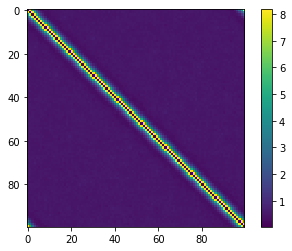

In [94]:
plt.imshow(np.abs(C-C_shuffled).sum(-1).sum(-1) ); plt.colorbar()

In [112]:
order.shape

(100000, 100)

In [115]:
C = utilities.covariance(data,data,c1=n_c,c2=n_c)
diag = C[np.arange(N),np.arange(N),:,:][:,np.arange(n_c),np.arange(n_c)]
C/= np.sqrt(diag[:,np.newaxis,:,np.newaxis] * diag[np.newaxis,:,np.newaxis,:])
C2D = np.swapaxes(C,1,2).reshape([n_c*N,n_c*N]) # Does the same thing as the commented code below.



order = np.argsort(np.random.randn(data.shape[0],N),axis=0)
shuffled_data = np.zeros_like(data)
for n in range(N):
    shuffled_data[:,n] = data[order[:,n],n]
C_shuffled = utilities.covariance(shuffled_data,shuffled_data,c1=n_c,c2=n_c)
diag_shuffled = C_shuffled[np.arange(N),np.arange(N),:,:][:,np.arange(n_c),np.arange(n_c)]
C_shuffled /= np.sqrt(diag_shuffled[:,np.newaxis,:,np.newaxis] * diag_shuffled[np.newaxis,:,np.newaxis,:])

C2D_shuffled = np.swapaxes(C_shuffled,1,2).reshape([n_c*N,n_c*N]) # Does the same thing as the commented code below.

# C2D = np.zeros([N*n_c,N*n_c])
# for i1 in range(N):
#     for i2 in range(N):
#         for c1 in range(n_c):
#             for c2 in range(n_c):
#                 C2D[i1*n_c+c1,i2*n_c+c2] = C[i1,i2,c1,c2]
 

lam,V = eigh(C2D);
idx = np.argmax(lam)
print(lam[idx])

lam_shuffled,V_shuffled = eigh(C2D_shuffled);
idx_shuffled = np.argmax(lam_shuffled)
print(lam_shuffled[idx_shuffled])



    
    

4.4341283
1.3281482


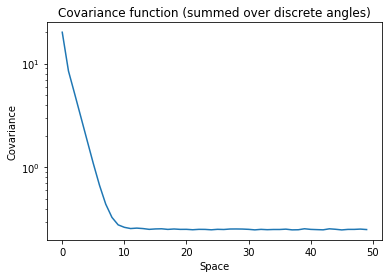

In [42]:
delta_C = np.zeros(N//2)
for k in range(N//2):
    index1 = np.arange(N)
    index2 = (np.arange(N) + k) % N
    delta_C[k] = np.abs(correlation)[index1,index2].mean()
plt.semilogy(delta_C)
plt.xlabel('Space')
plt.ylabel('Covariance')
plt.title('Covariance function (summed over discrete angles)')
plt.savefig('XY_covariance_function_N%s_S%s_beta%s.png'%(N,data.shape[0],beta));
plt.show()

In [51]:
C = utilities.covariance(data,data,c1=n_c,c2=n_c)
diag = C[np.arange(N),np.arange(N),:,:][:,np.arange(n_c),np.arange(n_c)]



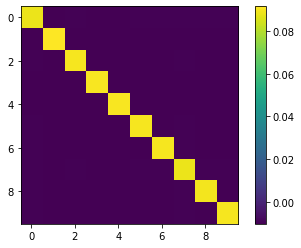

In [54]:
plt.imshow(C[0,0]); plt.colorbar()

In [68]:
q = 10
C = np.zeros([q,q])
for a in range(q):
    for b in range(q):
        if a==b:
            C[a,b] += 1/q
        C[a,b] -= 1/q**2

D = np.diag(C)
        
R = C/np.sqrt(D[np.newaxis,:]*D[:,np.newaxis])
print(R)
lam,V = np.linalg.eigh(R)
print(lam)

[[ 1.         -0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111
  -0.11111111 -0.11111111 -0.11111111 -0.11111111]
 [-0.11111111  1.         -0.11111111 -0.11111111 -0.11111111 -0.11111111
  -0.11111111 -0.11111111 -0.11111111 -0.11111111]
 [-0.11111111 -0.11111111  1.         -0.11111111 -0.11111111 -0.11111111
  -0.11111111 -0.11111111 -0.11111111 -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111  1.         -0.11111111 -0.11111111
  -0.11111111 -0.11111111 -0.11111111 -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111 -0.11111111  1.         -0.11111111
  -0.11111111 -0.11111111 -0.11111111 -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111  1.
  -0.11111111 -0.11111111 -0.11111111 -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111
   1.         -0.11111111 -0.11111111 -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111
  -0.11111111  1.         -0.11111111 -0.11111111]
 [-0.111

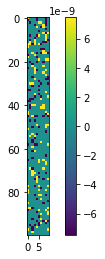

In [62]:
mu = utilities.average(data,c=n_c)
plt.imshow(diag- mu*(1-mu)); plt.colorbar()

In [108]:
data_check = np.random.randint(0,high=n_c,size=[int(1e5),100]).astype(np.int16)

C_check = utilities.covariance(data_check,data_check,c1=n_c,c2=n_c)
diag_check = C_check[np.arange(N),np.arange(N),:,:][:,np.arange(n_c),np.arange(n_c)]
C_check/= np.sqrt(diag_check[:,np.newaxis,:,np.newaxis] * diag_check[np.newaxis,:,np.newaxis,:])

C2D_check = np.swapaxes(C_check,1,2).reshape([n_c*N,n_c*N]) # Does the same thing as the commented code below.

# C2D = np.zeros([N*n_c,N*n_c])
# for i1 in range(N):
#     for i2 in range(N):
#         for c1 in range(n_c):
#             for c2 in range(n_c):
#                 C2D[i1*n_c+c1,i2*n_c+c2] = C[i1,i2,c1,c2]
 

lam_check,V_check = eigh(C2D_check);
idx_check = np.argmax(lam_check)
print(lam_check[idx_check])



1.3281778


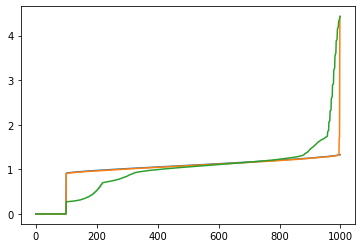

In [110]:
plt.plot(lam_check)
plt.plot(lam_shuffled)
plt.plot(lam)

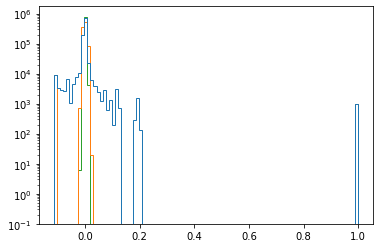

In [107]:
plt.hist([C.flatten(),C_shuffled.flatten(),C_check.flatten()],bins=100,log=True,histtype='step');